# Decision Tree Regression

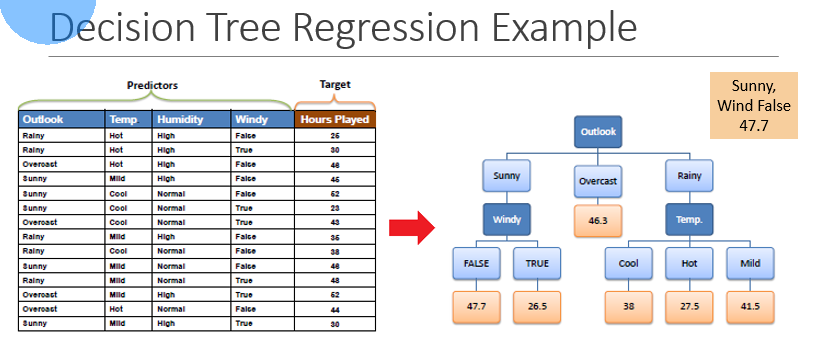

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

# Step 1 - Data Ingestion

In [2]:
import pandas as pd
df = pd.read_csv("PowerPlant.csv")
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


# Features
1. AT - Ambient Temperature degree celsius
2. V - Vacuum Pressure Pascals
3. AP - Atmospheric Pressure Pascals
4. RH - Relative Humidity Percentage
5. PE - Power Output in MW

# Step 2 - Perfom basic data quality checks

In [3]:
df.duplicated().sum()

np.int64(41)

In [4]:
df = df.drop_duplicates(keep="first").reset_index(drop = True)
df.shape

(9527, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9527 non-null   float64
 1   V       9527 non-null   float64
 2   AP      9527 non-null   float64
 3   RH      9527 non-null   float64
 4   PE      9527 non-null   float64
dtypes: float64(5)
memory usage: 372.3 KB


In [6]:
df.isna().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

# Step 3 - Seperate X and Y

In [7]:
X = df.drop(columns = ["PE"])
Y = df["PE"]

In [8]:
X.head()

,AT,V,AP,RH
0,8.34,40.77,1010.84,90.01
1,23.64,58.49,1011.40,74.20
2,29.74,56.90,1007.15,41.91
3,19.07,49.69,1007.22,76.79
4,11.80,40.66,1017.13,97.20


In [9]:
Y.head()

0    480.48
1    445.75
2    438.76
3    453.09
4    464.43
Name: PE, dtype: float64

# Apply Train Test split

In [10]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

In [11]:
xtrain.shape

(7621, 4)

In [12]:
xtest.shape

(1906, 4)

# Apply preprocessing on X

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [14]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
).set_output(transform="pandas")

num_pipe.fit(xtrain)

,steps,"[('simpleimputer', ...), ('standardscaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [15]:
xtrain_pre = num_pipe.transform(xtrain)
xtrain_pre.head()

,AT,V,AP,RH
5695,-0.154993,0.323693,0.084610,1.818417
7300,-1.504241,-1.151828,0.319064,0.907637
9066,-0.889599,-0.953518,0.288703,0.987193
6424,1.401831,1.221597,-0.485502,-1.086753
6773,-0.828943,-0.940927,0.793033,1.506365


In [16]:
xtest_pre = num_pipe.transform(xtest)
xtest_pre.head()

,AT,V,AP,RH
1087,1.831812,1.118507,-0.131290,-1.419379
6308,-1.508285,-1.243114,0.039069,-0.470879
8021,-1.471891,-1.416242,0.394967,-1.086753
9483,0.149632,0.647127,0.727251,-0.005201
4459,-0.037726,1.126376,-0.367431,1.586607


# Build the model

In [17]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(
    max_depth = 1,
    min_samples_leaf= 5,
    min_samples_split= 5,
    criterion= "squared_error",
    random_state = 42
)
dtr.fit(xtrain_pre, ytrain)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,5
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [18]:
dtr.score(xtrain_pre, ytrain)

0.71765957297802

In [19]:
dtr.score(xtest_pre, ytest)

0.7251450398190283

# Evaluate the model

In [20]:
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

def evaluate_model(model, x, y):
    ypred = model.predict(x)
    rmse = root_mean_squared_error(y, ypred)
    mae = mean_absolute_error(y, ypred)
    mape = mean_absolute_percentage_error(y, ypred)
    r2 = r2_score(y, ypred)
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"MAPE : {mape:.2%}")
    print(f"R2 : {r2:.2%}")

In [21]:
evaluate_model(dtr, xtrain_pre, ytrain)

RMSE : 9.01
MAE : 7.37
MAPE : 1.62%
R2 : 71.77%


In [22]:
evaluate_model(dtr, xtest_pre, ytest)

RMSE : 9.11
MAE : 7.36
MAPE : 1.61%
R2 : 72.51%


# Hyperparameter tuning

In [23]:
params = {
    "max_depth": [8, 9, 10, 11, 12, 13],
    "min_samples_split": [5, 6, 7, 8, 9],
    "min_samples_leaf": [5, 6, 7, 8, 9],
    "criterion": ["squared_error", "absolute_error"]
}

In [24]:
from sklearn.model_selection import RandomizedSearchCV

model = DecisionTreeRegressor(random_state=42)
rscv = RandomizedSearchCV(model, params, cv=5, scoring="r2")
rscv.fit(xtrain_pre, ytrain)

,estimator,DecisionTreeR...ndom_state=42)
,param_distributions,"{'criterion': ['squared_error', 'absolute_error'], 'max_depth': [8, 9, ...], 'min_samples_leaf': [5, 6, ...], 'min_samples_split': [5, 6, ...]}"
,n_iter,10
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [25]:
rscv.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_depth': 9,
 'criterion': 'squared_error'}

In [26]:
rscv.best_score_

np.float64(0.9402720836430726)

In [27]:
best_dtr = rscv.best_estimator_
best_dtr

,criterion,'squared_error'
,splitter,'best'
,max_depth,9
,min_samples_split,5
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


# Evalute the model

In [28]:
evaluate_model(best_dtr, xtrain_pre, ytrain)

RMSE : 3.34
MAE : 2.46
MAPE : 0.54%
R2 : 96.11%


In [29]:
evaluate_model(best_dtr, xtest_pre, ytest)

RMSE : 3.93
MAE : 2.91
MAPE : 0.64%
R2 : 94.87%


# Plot the decision Tree

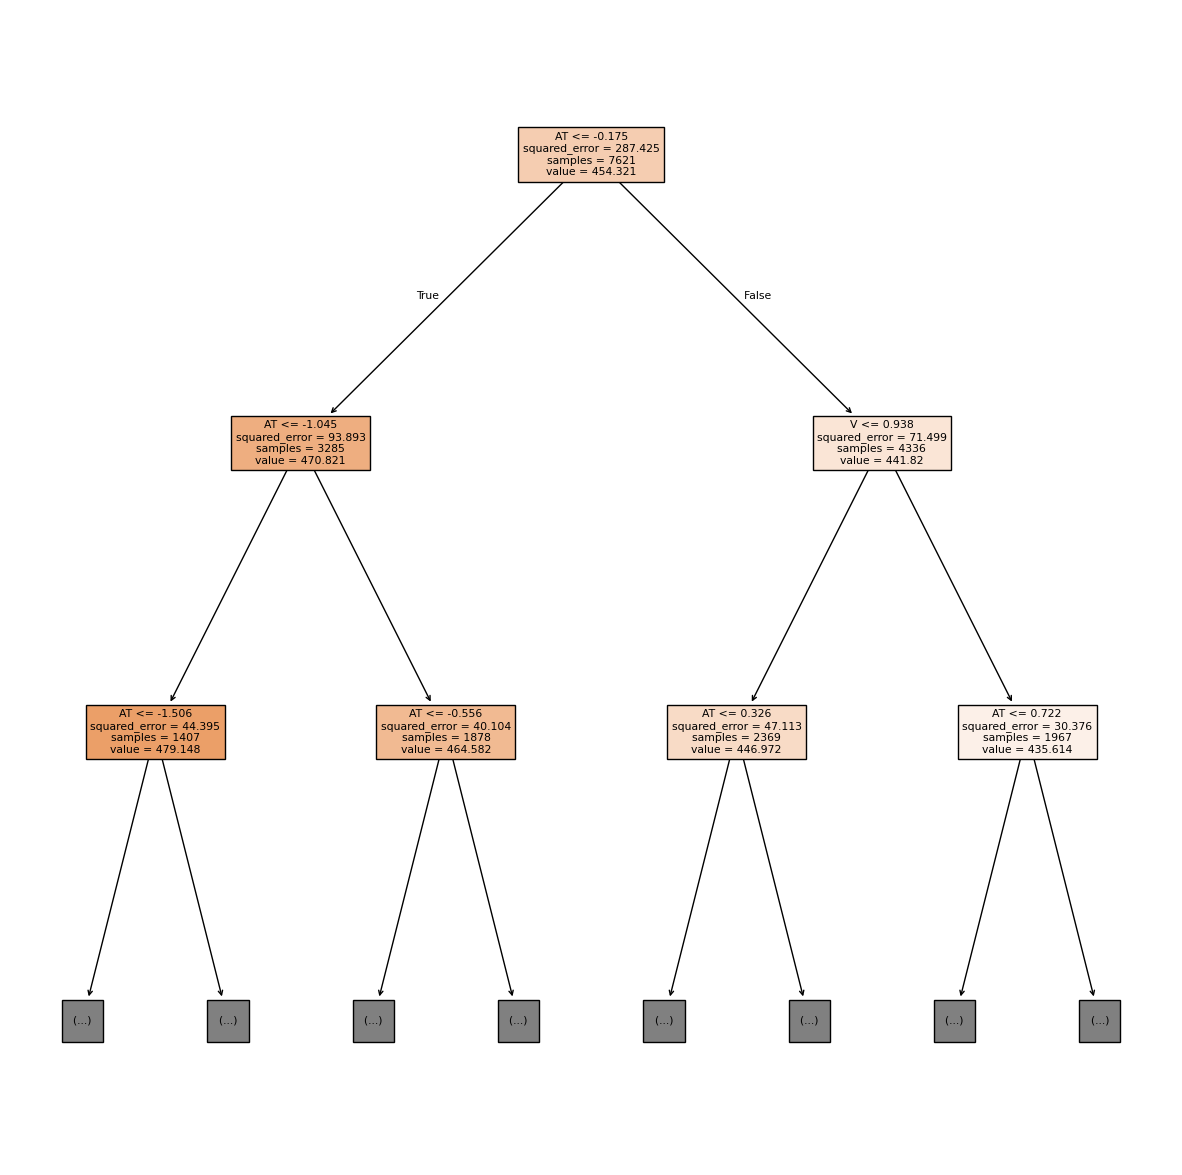

In [32]:
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree

plt.figure(figsize = (15, 15))
plot_tree(best_dtr, feature_names=xtrain_pre.columns, max_depth=2, filled=True)
plt.show()

In [33]:
best_dtr.feature_importances_

array([0.89559909, 0.08640664, 0.01040362, 0.00759064])

In [34]:
xtrain.columns

Index(['AT', 'V', 'AP', 'RH'], dtype='object')

In [36]:
imp = pd.Series(best_dtr.feature_importances_, index = xtrain.columns)
imp

AT    0.895599
V     0.086407
AP    0.010404
RH    0.007591
dtype: float64

<Axes: >

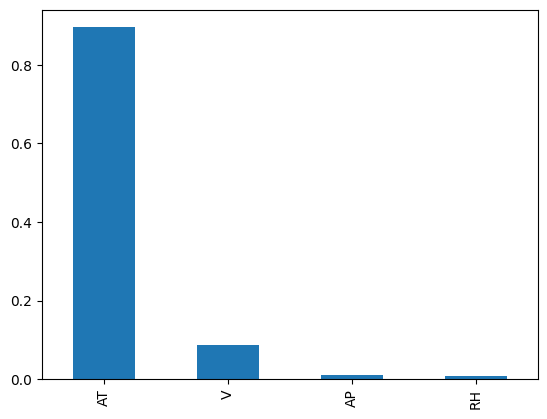

In [37]:
imp.plot(kind = "bar")

# Out of sample prediction

In [38]:
xnew = pd.read_csv("test_PowerPlant.csv")
xnew.head()

,AT,V,AP,RH
0,22.49,58.82,1009.73,85.19
1,28.88,54.89,1007.16,46.60
2,27.89,73.21,1001.32,85.88
3,25.69,62.26,1011.38,74.08
4,12.16,40.81,1025.79,70.97


In [39]:
num_pipe

,steps,"[('simpleimputer', ...), ('standardscaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [40]:
xnew_pre = num_pipe.transform(xnew)
xnew_pre.head()

,AT,V,AP,RH
0,0.380123,0.355958,-0.596825,0.810249
1,1.241431,0.046688,-1.030313,-1.836363
2,1.107989,1.488371,-2.015358,0.857571
3,0.811451,0.626666,-0.318516,0.048294
4,-1.012258,-1.061330,2.112049,-0.164999


In [ ]:
preds = best_dtr.predict(xnew_pre)
preds

array([445.41838235, 440.0925    , 433.53547619, 443.73473118,
       465.58888889, 445.41838235, 450.10663551, 476.23882353,
       469.31466667, 475.35747664, 454.21137931, 472.501     ,
       450.10663551, 438.87538462, 433.89391304, 432.14096774,
       450.10663551, 463.53727273, 443.765     , 432.55388235,
       434.1629078 , 473.08875   , 480.745     , 433.33285714,
       468.32166667, 443.73473118, 440.15714286, 432.55388235,
       439.96318182, 445.41838235, 482.76714286, 465.68523364,
       439.98058824, 442.60443662, 434.1629078 , 443.58      ,
       466.84769231, 470.25211382, 434.37727273, 472.83826087,
       454.72064516, 454.21137931, 484.388     , 434.57802632,
       454.58222222, 442.60443662, 455.56486486, 449.17807692,
       454.58222222, 456.30181818, 477.78337165, 457.3016129 ,
       471.62320312, 463.27781955, 467.37358491, 446.5884    ,
       432.14096774, 446.96878049, 470.25211382, 472.83826087,
       448.045     , 433.42956522, 456.627     , 449.17

In [42]:
xnew["PE_pred"] = preds.round(2)

In [43]:
xnew

,AT,V,AP,RH,PE_pred
0,22.49,58.82,1009.73,85.19,445.42
1,28.88,54.89,1007.16,46.60,440.09
2,27.89,73.21,1001.32,85.88,433.54
3,25.69,62.26,1011.38,74.08,443.73
4,12.16,40.81,1025.79,70.97,465.59
...,...,...,...,...,...
95,26.35,69.48,1008.45,70.47,434.16
96,11.78,39.96,1011.37,82.95,475.36
97,5.62,41.38,1020.91,86.21,486.83
98,24.96,74.99,1008.25,80.52,437.97


In [44]:
xnew.to_csv("results.csv", index = False)

# Save the model object

In [45]:
import joblib
joblib.dump(num_pipe, "pre.joblib")

['pre.joblib']

In [46]:
joblib.dump(best_dtr, "dtr_model.joblib")

['dtr_model.joblib']

# Load the model

In [47]:
p = joblib.load("pre.joblib")
p

,steps,"[('simpleimputer', ...), ('standardscaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [48]:
m = joblib.load("dtr_model.joblib")
m

,criterion,'squared_error'
,splitter,'best'
,max_depth,9
,min_samples_split,5
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0
